In [176]:
#importando bibliotecas

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.style as style
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
%matplotlib inline

# setting up plot style 
style.use('seaborn-poster')

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.expand_frame_repr', False)


In [374]:
#import dataset

df = pd.read_csv('satisfaction.csv')
df.drop(columns = 'not_defined', inplace = True)
df.head()

,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_city,customer_state,review_score,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,boleto,credit_card,debit_card,voucher
0,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,sao paulo,SP,4.0,29.99,8.72,utilidades_domesticas,40.0,268.0,4.0,0.0,1.0,0.0,2.0
1,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,barreiras,BA,4.0,118.70,22.76,perfumaria,29.0,178.0,1.0,1.0,0.0,0.0,0.0
2,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,vianopolis,GO,5.0,159.90,19.22,automotivo,46.0,232.0,1.0,0.0,3.0,0.0,0.0
3,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,sao goncalo do amarante,RN,5.0,45.00,27.20,pet_shop,59.0,468.0,3.0,0.0,1.0,0.0,0.0
4,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,santo andre,SP,5.0,19.90,8.72,papelaria,38.0,316.0,4.0,0.0,1.0,0.0,0.0


In [375]:
df = df[['review_score','price', 'freight_value','boleto', 'credit_card', 'debit_card']]


In [376]:
#retirando as colunas product_name_lenght e product_description_lenght

#df.drop(columns = ['product_name_lenght', 'product_description_lenght',
#                   'order_purchase_timestamp',
#                   'order_approved_at',
#                   'order_delivered_carrier_date',
#                   'order_delivered_customer_date',
#                   'order_estimated_delivery_date',
#                   'voucher',
#                   'customer_city',
#                   'customer_state'],
#        inplace = True)
df.columns

Index(['review_score', 'price', 'freight_value', 'boleto', 'credit_card', 'debit_card'], dtype='object')

In [206]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92309 entries, 0 to 92308
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   review_score           92309 non-null  float64
 1   price                  92309 non-null  float64
 2   freight_value          92309 non-null  float64
 3   product_category_name  92309 non-null  object 
 4   product_photos_qty     92309 non-null  float64
 5   boleto                 92309 non-null  float64
 6   credit_card            92309 non-null  float64
 7   debit_card             92309 non-null  float64
dtypes: float64(7), object(1)
memory usage: 5.6+ MB


# Feature Engineering

## Date Columns

Add columns that are the difference between `order purchase` and anothers date columns

In [264]:
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])
df['order_approved_at'] = pd.to_datetime(df['order_approved_at'])
df['order_delivered_carrier_date'] = pd.to_datetime(df['order_delivered_carrier_date'])
df['order_delivered_customer_date'] = pd.to_datetime(df['order_delivered_customer_date'])
df['order_estimated_delivery_date'] = pd.to_datetime(df['order_estimated_delivery_date'])

In [265]:
df['diff_approved'] = df['order_approved_at'] - df['order_purchase_timestamp'] #diff data aprovação da compra - data da compra
df['diff_carrier'] = df['order_delivered_carrier_date'] - df['order_purchase_timestamp']
df['diff_customer'] = df['order_delivered_customer_date'] - df['order_purchase_timestamp']
df['diff_estimate'] = df['order_estimated_delivery_date'] - df['order_purchase_timestamp']
df['diff_est_del'] = df['order_estimated_delivery_date'] - df['order_delivered_customer_date']

#transforming the values in days difference
df['diff_approved']=df['diff_approved']/np.timedelta64(1,'D')
df['diff_carrier']=df['diff_carrier']/np.timedelta64(1,'D')
df['diff_customer']=df['diff_customer']/np.timedelta64(1,'D')
df['diff_estimate']=df['diff_estimate']/np.timedelta64(1,'D')
df['diff_est_del']=df['diff_est_del']/np.timedelta64(1,'D')

df.head()

,review_score,price,freight_value,boleto,credit_card,debit_card,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,diff_approved,diff_carrier,diff_customer,diff_estimate,diff_est_del
0,4.0,29.99,8.72,0.0,1.0,0.0,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,0.007431,2.373924,8.436574,15.544063,7.107488
1,4.0,118.70,22.76,1.0,0.0,0.0,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,1.279745,1.742627,13.782037,19.137766,5.355729
2,5.0,159.90,19.22,0.0,3.0,0.0,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,0.011505,0.216100,9.394213,26.639711,17.245498
3,5.0,45.00,27.20,0.0,1.0,0.0,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,0.012419,3.758252,13.208750,26.188819,12.980069
4,5.0,19.90,8.72,0.0,1.0,0.0,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,0.042940,0.936053,2.873877,12.112049,9.238171


In [266]:
#drop date columns
cols = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date',
        'order_delivered_customer_date', 'order_estimated_delivery_date']

df.drop(columns = cols, axis= 1, inplace = True)
df.head()

,review_score,price,freight_value,boleto,credit_card,debit_card,diff_approved,diff_carrier,diff_customer,diff_estimate,diff_est_del
0,4.0,29.99,8.72,0.0,1.0,0.0,0.007431,2.373924,8.436574,15.544063,7.107488
1,4.0,118.70,22.76,1.0,0.0,0.0,1.279745,1.742627,13.782037,19.137766,5.355729
2,5.0,159.90,19.22,0.0,3.0,0.0,0.011505,0.216100,9.394213,26.639711,17.245498
3,5.0,45.00,27.20,0.0,1.0,0.0,0.012419,3.758252,13.208750,26.188819,12.980069
4,5.0,19.90,8.72,0.0,1.0,0.0,0.042940,0.936053,2.873877,12.112049,9.238171


In [267]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92309 entries, 0 to 92308
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   review_score   92309 non-null  float64
 1   price          92309 non-null  float64
 2   freight_value  92309 non-null  float64
 3   boleto         92309 non-null  float64
 4   credit_card    92309 non-null  float64
 5   debit_card     92309 non-null  float64
 6   diff_approved  92309 non-null  float64
 7   diff_carrier   92309 non-null  float64
 8   diff_customer  92309 non-null  float64
 9   diff_estimate  92309 non-null  float64
 10  diff_est_del   92309 non-null  float64
dtypes: float64(11)
memory usage: 7.7 MB


## Customer city columns

In [50]:
df['customer_city'].value_counts()

sao paulo                14545
rio de janeiro            6338
belo horizonte            2571
brasilia                  1998
curitiba                  1414
                         ...  
santo antonio do taua        1
sao pedro do iguacu          1
sao pedro do turvo           1
ibiaca                       1
jacareacanga                 1
Name: customer_city, Length: 3990, dtype: int64

In [51]:
#list of capitals:

capitals = ["rio branco",
"maceio",
"macapa",
"manaus",
"salvador",
"fortaleza",
"brasilia",
"vitria",
"goiania",
"sao luis",
"cuiaba",
"campo grande",
"belo horizonte",
"belem",
"joao pessoa",
"curitiba",
"recife",
"teresina",
"rio de janeiro",
"natal",
"porto alegre",
"porto velho",
"boa vista",
"florianopolis",
"sao paulo",
"aracaju",
"palmas" ]

In [52]:
#create a new column based capitals list
def cap (row):
    if row['customer_city'] in capitals:
        val = 1
    else:
        val = 0
    return val

In [53]:
df['customer_capital'] = df.apply(cap, axis = 1)
df.head()

,customer_city,customer_state,review_score,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,boleto,credit_card,debit_card,voucher,diff_approved,diff_carrier,diff_customer,diff_estimate,diff_est_del,customer_capital
0,sao paulo,SP,4.0,29.99,8.72,utilidades_domesticas,40.0,268.0,4.0,0.0,1.0,0.0,2.0,0.007431,2.373924,8.436574,15.544063,7.107488,1
1,barreiras,BA,4.0,118.70,22.76,perfumaria,29.0,178.0,1.0,1.0,0.0,0.0,0.0,1.279745,1.742627,13.782037,19.137766,5.355729,0
2,vianopolis,GO,5.0,159.90,19.22,automotivo,46.0,232.0,1.0,0.0,3.0,0.0,0.0,0.011505,0.216100,9.394213,26.639711,17.245498,0
3,sao goncalo do amarante,RN,5.0,45.00,27.20,pet_shop,59.0,468.0,3.0,0.0,1.0,0.0,0.0,0.012419,3.758252,13.208750,26.188819,12.980069,0
4,santo andre,SP,5.0,19.90,8.72,papelaria,38.0,316.0,4.0,0.0,1.0,0.0,0.0,0.042940,0.936053,2.873877,12.112049,9.238171,0


In [54]:
#drop the city column
df.drop(columns = 'customer_city', axis = 1, inplace = True)
df.head()

,customer_state,review_score,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,boleto,credit_card,debit_card,voucher,diff_approved,diff_carrier,diff_customer,diff_estimate,diff_est_del,customer_capital
0,SP,4.0,29.99,8.72,utilidades_domesticas,40.0,268.0,4.0,0.0,1.0,0.0,2.0,0.007431,2.373924,8.436574,15.544063,7.107488,1
1,BA,4.0,118.70,22.76,perfumaria,29.0,178.0,1.0,1.0,0.0,0.0,0.0,1.279745,1.742627,13.782037,19.137766,5.355729,0
2,GO,5.0,159.90,19.22,automotivo,46.0,232.0,1.0,0.0,3.0,0.0,0.0,0.011505,0.216100,9.394213,26.639711,17.245498,0
3,RN,5.0,45.00,27.20,pet_shop,59.0,468.0,3.0,0.0,1.0,0.0,0.0,0.012419,3.758252,13.208750,26.188819,12.980069,0
4,SP,5.0,19.90,8.72,papelaria,38.0,316.0,4.0,0.0,1.0,0.0,0.0,0.042940,0.936053,2.873877,12.112049,9.238171,0


## Customer State

In [55]:
df.customer_state.value_counts()

SP    38964
RJ    11812
MG    10856
RS     5123
PR     4708
SC     3351
BA     3048
DF     2006
ES     1891
GO     1868
PE     1514
CE     1190
PA      889
MT      857
MS      681
MA      676
PB      485
RN      455
PI      446
AL      379
SE      312
TO      260
RO      227
AM      143
AC       73
AP       61
RR       34
Name: customer_state, dtype: int64

In [56]:
#create a regions list
norte = ['AM', 'RR', 'AP', 'PA', 'TO', 'RO', 'AC']
nordeste = ['MA', 'PI', 'CE', 'RN', 'PE', 'PB', 'SE', 'AL', 'BA']
centro_oeste = ['MT', 'MS', 'GO']
sul = ['PR', 'RS', 'SC']
sudeste = ['SP', 'RJ', 'ES', 'MG']

In [57]:
#create a new feature based in region list
def region (row):
    val = ""
    if row['customer_state'] in norte:
        val = 'norte'
    elif row['customer_state'] in nordeste:
        val = 'nordeste'
    elif row['customer_state'] in centro_oeste:
        val = 'centro_oeste'
    elif row['customer_state'] in sul:
        val = 'sul'
    elif row['customer_state'] in sudeste:
        val = 'sudeste'
    return val

In [58]:
df['customer_region'] = df.apply(region, axis = 1)

In [59]:
#drop the customer_state colum
df.drop(columns = 'customer_state', axis = 1, inplace = True)
df.head()

,review_score,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,boleto,credit_card,debit_card,voucher,diff_approved,diff_carrier,diff_customer,diff_estimate,diff_est_del,customer_capital,customer_region
0,4.0,29.99,8.72,utilidades_domesticas,40.0,268.0,4.0,0.0,1.0,0.0,2.0,0.007431,2.373924,8.436574,15.544063,7.107488,1,sudeste
1,4.0,118.70,22.76,perfumaria,29.0,178.0,1.0,1.0,0.0,0.0,0.0,1.279745,1.742627,13.782037,19.137766,5.355729,0,nordeste
2,5.0,159.90,19.22,automotivo,46.0,232.0,1.0,0.0,3.0,0.0,0.0,0.011505,0.216100,9.394213,26.639711,17.245498,0,centro_oeste
3,5.0,45.00,27.20,pet_shop,59.0,468.0,3.0,0.0,1.0,0.0,0.0,0.012419,3.758252,13.208750,26.188819,12.980069,0,nordeste
4,5.0,19.90,8.72,papelaria,38.0,316.0,4.0,0.0,1.0,0.0,0.0,0.042940,0.936053,2.873877,12.112049,9.238171,0,sudeste


In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92309 entries, 0 to 92308
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   review_score                92309 non-null  float64
 1   price                       92309 non-null  float64
 2   freight_value               92309 non-null  float64
 3   product_category_name       92309 non-null  object 
 4   product_name_lenght         92309 non-null  float64
 5   product_description_lenght  92309 non-null  float64
 6   product_photos_qty          92309 non-null  float64
 7   boleto                      92309 non-null  float64
 8   credit_card                 92309 non-null  float64
 9   debit_card                  92309 non-null  float64
 10  voucher                     92309 non-null  float64
 11  diff_approved               92309 non-null  float64
 12  diff_carrier                92309 non-null  float64
 13  diff_customer               923

## Product category

In [207]:
product_percent = df['product_category_name'].value_counts(normalize=True) * 100

In [208]:
products = product_percent[product_percent < 0.5]
products = products.index.tolist()
products

['casa_construcao',
 'alimentos',
 'moveis_sala',
 'casa_conforto',
 'audio',
 'bebidas',
 'livros_tecnicos',
 'market_place',
 'fashion_calcados',
 'climatizacao',
 'industria_comercio_e_negocios',
 'construcao_ferramentas_iluminacao',
 'moveis_cozinha_area_de_servico_jantar_e_jardim',
 'eletrodomesticos_2',
 'alimentos_bebidas',
 'construcao_ferramentas_jardim',
 'telefonia_fixa',
 'artes',
 'pcs',
 'agro_industria_e_comercio',
 'construcao_ferramentas_seguranca',
 'sinalizacao_e_seguranca',
 'artigos_de_natal',
 'fashion_underwear_e_moda_praia',
 'fashion_roupa_masculina',
 'construcao_ferramentas_ferramentas',
 'moveis_quarto',
 'tablets_impressao_imagem',
 'portateis_casa_forno_e_cafe',
 'cine_foto',
 'dvds_blu_ray',
 'livros_importados',
 'artigos_de_festas',
 'musica',
 'moveis_colchao_e_estofado',
 'fashion_roupa_feminina',
 'flores',
 'fashion_esporte',
 'casa_conforto_2',
 'artes_e_artesanato',
 'fraldas_higiene',
 'la_cuisine',
 'cds_dvds_musicais',
 'portateis_cozinha_e_pre

In [209]:
df = df[~df.product_category_name.isin(products)]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 85769 entries, 0 to 92308
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   review_score           85769 non-null  float64
 1   price                  85769 non-null  float64
 2   freight_value          85769 non-null  float64
 3   product_category_name  85769 non-null  object 
 4   product_photos_qty     85769 non-null  float64
 5   boleto                 85769 non-null  float64
 6   credit_card            85769 non-null  float64
 7   debit_card             85769 non-null  float64
dtypes: float64(7), object(1)
memory usage: 5.9+ MB


In [210]:
df.product_category_name.value_counts()

cama_mesa_banho                      9116
beleza_saude                         8188
esporte_lazer                        7147
informatica_acessorios               6220
moveis_decoracao                     6090
utilidades_domesticas                5393
relogios_presentes                   5179
telefonia                            3758
automotivo                           3621
brinquedos                           3606
cool_stuff                           3298
ferramentas_jardim                   3259
perfumaria                           2963
bebes                                2616
eletronicos                          2331
papelaria                            2186
fashion_bolsas_e_acessorios          1789
pet_shop                             1624
no info                              1323
moveis_escritorio                    1103
malas_acessorios                      966
consoles_games                        926
eletrodomesticos                      721
construcao_ferramentas_construcao 

# Transforming Categorical Values

### Encoding Independent variables

In [268]:
# Get list of categorical variables
datatype = df.dtypes
object_cols = datatype[(datatype == 'object') | (datatype == 'category')].index.tolist()
#object_cols = list(s[s].index)

print("Categorical variables:")
print(object_cols)

Categorical variables:
[]


In [232]:
df.columns

Index(['review_score', 'price', 'freight_value', 'boleto', 'credit_card', 'debit_card'], dtype='object')

In [217]:
#get dummies
dummy = pd.get_dummies(df[['product_category_name']], drop_first=True)

#concat dataframe
df = pd.concat([df, dummy], axis = 1)

#drop the columns:
df.drop(columns = object_cols, axis= 1, inplace = True)

#check
df.head()

,review_score,price,freight_value,product_photos_qty,boleto,credit_card,debit_card,product_category_name_bebes,product_category_name_beleza_saude,product_category_name_brinquedos,product_category_name_cama_mesa_banho,product_category_name_consoles_games,product_category_name_construcao_ferramentas_construcao,product_category_name_cool_stuff,product_category_name_eletrodomesticos,product_category_name_eletronicos,product_category_name_eletroportateis,product_category_name_esporte_lazer,product_category_name_fashion_bolsas_e_acessorios,product_category_name_ferramentas_jardim,product_category_name_informatica_acessorios,product_category_name_instrumentos_musicais,product_category_name_livros_interesse_geral,product_category_name_malas_acessorios,product_category_name_moveis_decoracao,product_category_name_moveis_escritorio,product_category_name_no info,product_category_name_papelaria,product_category_name_perfumaria,product_category_name_pet_shop,product_category_name_relogios_presentes,product_category_name_telefonia,product_category_name_utilidades_domesticas
0,4.0,29.99,8.72,4.0,0.0,1.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,4.0,118.70,22.76,1.0,1.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,5.0,159.90,19.22,1.0,0.0,3.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,5.0,45.00,27.20,3.0,0.0,1.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,5.0,19.90,8.72,4.0,0.0,1.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [218]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 85769 entries, 0 to 92308
Data columns (total 33 columns):
 #   Column                                                   Non-Null Count  Dtype  
---  ------                                                   --------------  -----  
 0   review_score                                             85769 non-null  float64
 1   price                                                    85769 non-null  float64
 2   freight_value                                            85769 non-null  float64
 3   product_photos_qty                                       85769 non-null  float64
 4   boleto                                                   85769 non-null  float64
 5   credit_card                                              85769 non-null  float64
 6   debit_card                                               85769 non-null  float64
 7   product_category_name_bebes                              85769 non-null  uint8  
 8   product_category_name_bele

# Model

Text(0.5, 1.0, 'Correlation Heatmap')

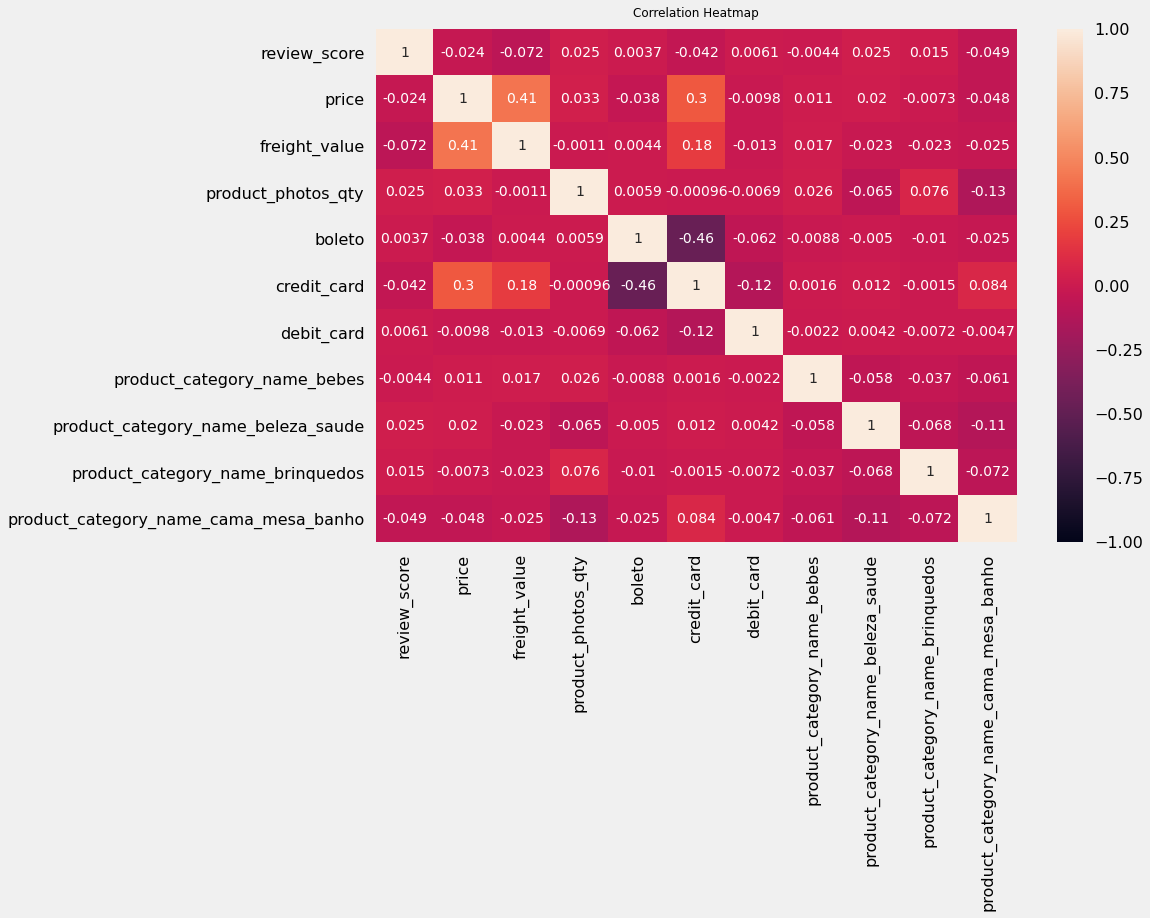

In [219]:
heatmap = sns.heatmap(df.iloc[:,0:11].corr(), vmin=-1, vmax=1, annot=True)

heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


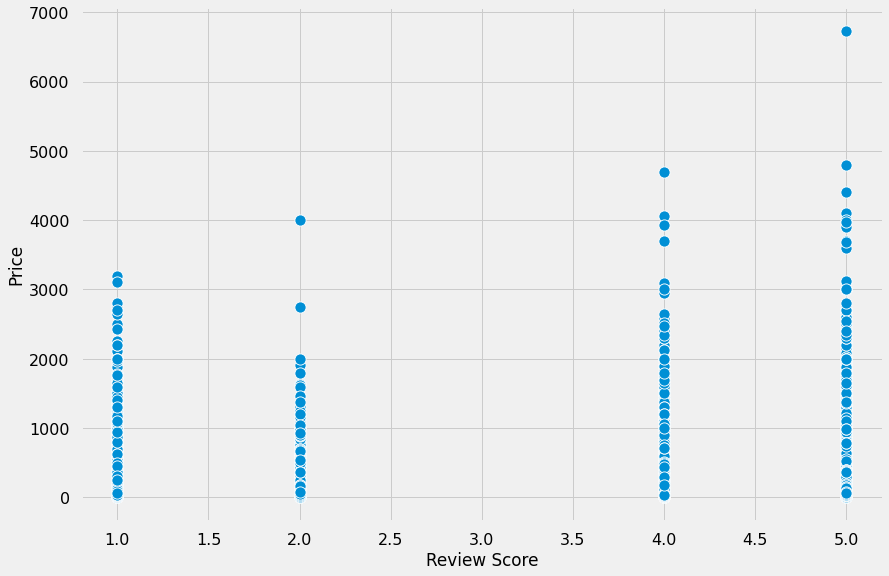

In [220]:
sns.scatterplot(df.iloc[:,0], df.iloc[:, 1])
plt.xlabel('Review Score')
plt.ylabel('Price')
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


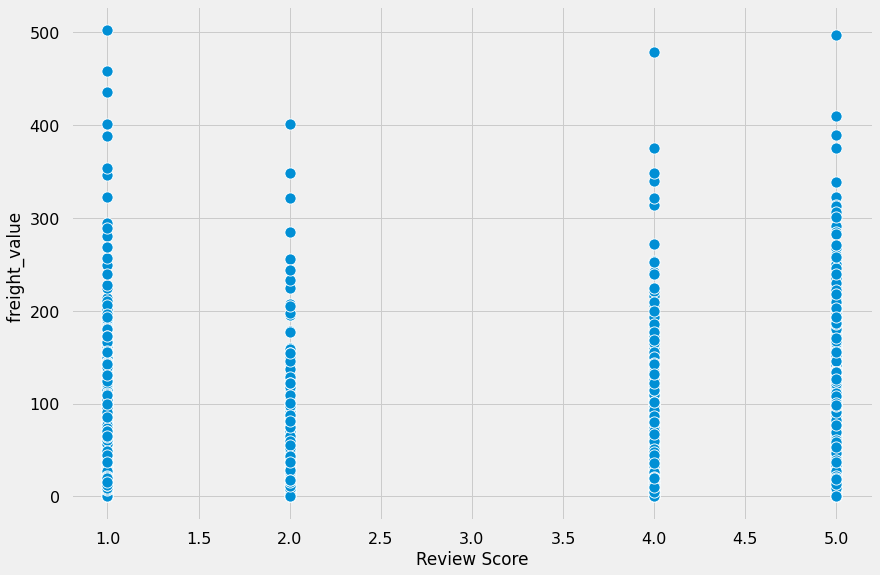

In [221]:
sns.scatterplot(df.iloc[:,0], df.iloc[:, 2])
plt.xlabel('Review Score')
plt.ylabel('freight_value ')
plt.show()

In [377]:
scaler = StandardScaler()

X = scaler.fit_transform(df)
#X = df.loc[:,:]

### Elbow Curve

In [378]:
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42}
# A list holds the SSE values for each k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(X)
    sse.append(kmeans.inertia_)


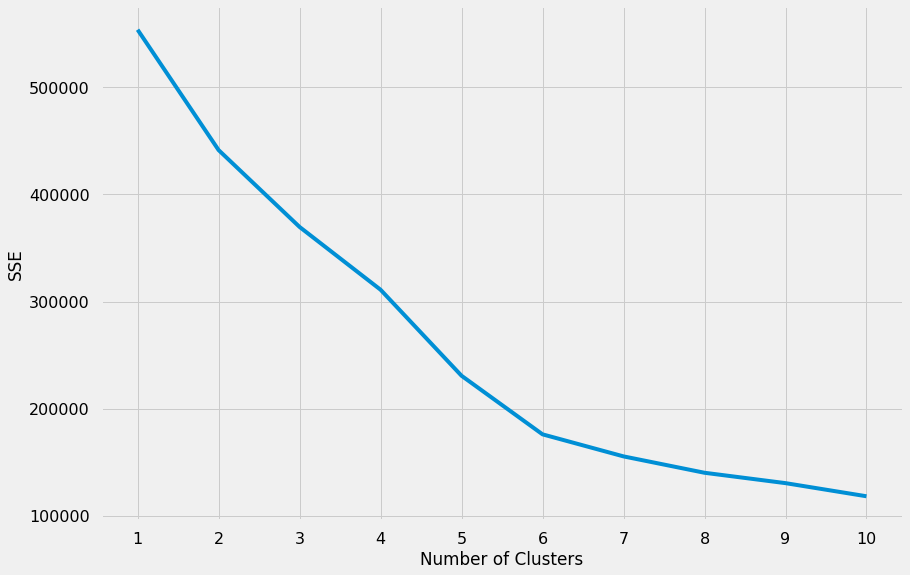

In [379]:
plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [380]:
kmeans = KMeans(n_clusters=6,
                init='random',
                n_init = 10,
                max_iter = 300,
                random_state = 42)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)


In [349]:
y_kmeans

array([3, 5, 1, ..., 1, 1, 2])

In [339]:
X[:, 0]

array([-0.15999027, -0.15999027,  0.58857997, ...,  0.58857997,
       -1.65713076,  0.58857997])

In [341]:
X[:, 2]

array([-0.64781066,  0.04306718, -0.13112851, ...,  2.12258982,
        2.91778826, -0.17344724])

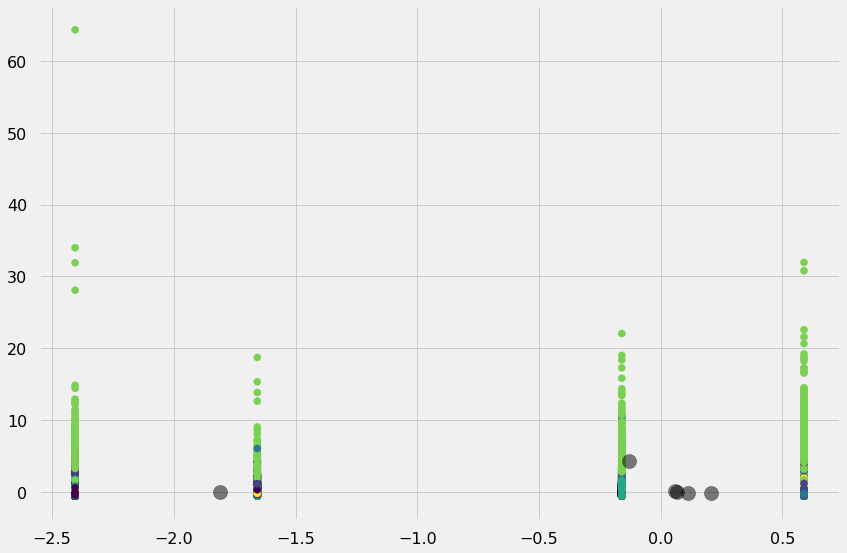

In [273]:
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

In [345]:
df.head()

,review_score,price,freight_value,boleto,credit_card,debit_card,diff_approved,diff_carrier,diff_customer,diff_estimate,diff_est_del,cluster
0,4.0,29.99,8.72,0.0,1.0,0.0,0.007431,2.373924,8.436574,15.544063,7.107488,3
1,4.0,118.70,22.76,1.0,0.0,0.0,1.279745,1.742627,13.782037,19.137766,5.355729,5
2,5.0,159.90,19.22,0.0,3.0,0.0,0.011505,0.216100,9.394213,26.639711,17.245498,1
3,5.0,45.00,27.20,0.0,1.0,0.0,0.012419,3.758252,13.208750,26.188819,12.980069,3
4,5.0,19.90,8.72,0.0,1.0,0.0,0.042940,0.936053,2.873877,12.112049,9.238171,3


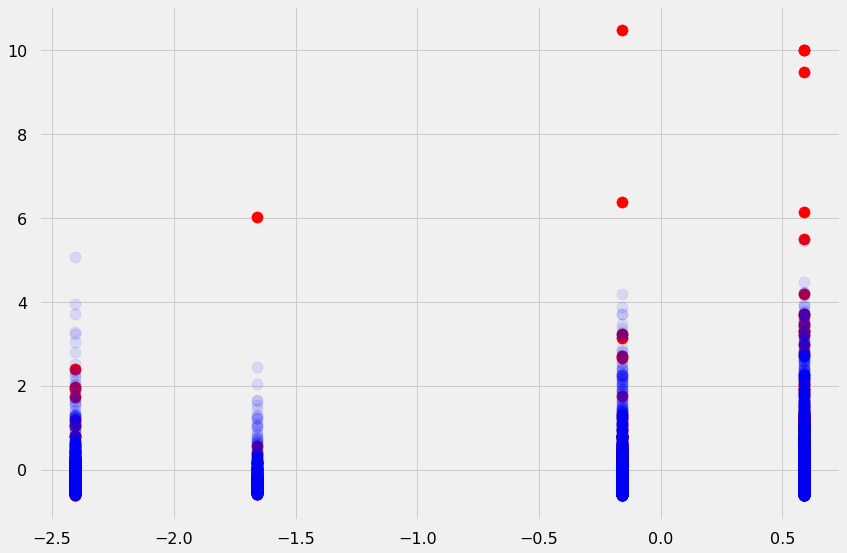

In [361]:
#filter rows of original data
filtered_label2 = X[y_kmeans == 2]
 
filtered_label5 = X[y_kmeans == 5]
 
#Plotting the results
plt.scatter(filtered_label2[:,0] , filtered_label2[:,1] , color = 'red')
plt.scatter(filtered_label5[:,0] , filtered_label5[:,1] , color = 'blue', alpha = .1)
plt.show()

0
1
2
3
4
5


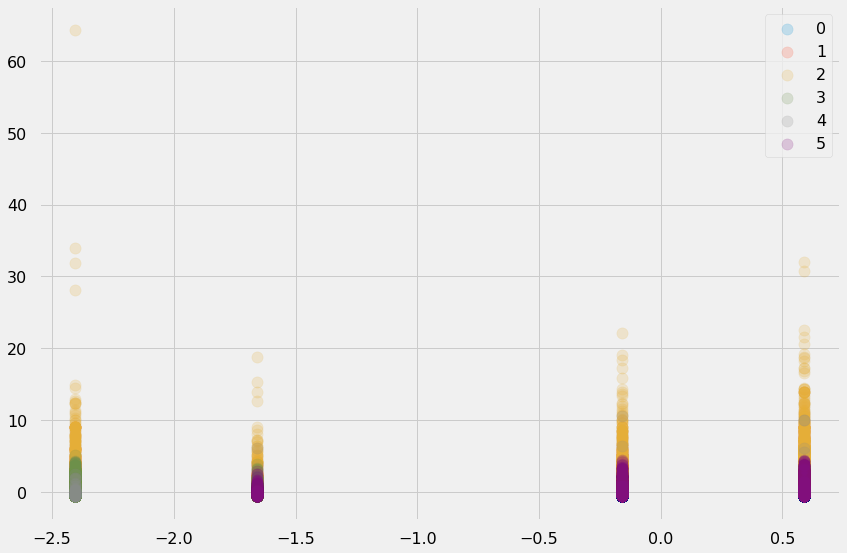

In [381]:
#Getting unique labels
 
u_labels = np.unique(y_kmeans)
 
#plotting the results:
 
for i in u_labels:
    #print(i)
    plt.scatter(X[y_kmeans == i , 0] , X[y_kmeans == i , 1], label = i, alpha = .2)
plt.legend()
plt.show()

In [274]:
df['cluster'] = y_kmeans
df.head()

,review_score,price,freight_value,boleto,credit_card,debit_card,diff_approved,diff_carrier,diff_customer,diff_estimate,diff_est_del,cluster
0,4.0,29.99,8.72,0.0,1.0,0.0,0.007431,2.373924,8.436574,15.544063,7.107488,3
1,4.0,118.70,22.76,1.0,0.0,0.0,1.279745,1.742627,13.782037,19.137766,5.355729,5
2,5.0,159.90,19.22,0.0,3.0,0.0,0.011505,0.216100,9.394213,26.639711,17.245498,1
3,5.0,45.00,27.20,0.0,1.0,0.0,0.012419,3.758252,13.208750,26.188819,12.980069,3
4,5.0,19.90,8.72,0.0,1.0,0.0,0.042940,0.936053,2.873877,12.112049,9.238171,3


------------------------------------

## Applying PCA

In [296]:
pca = PCA(n_components=2)
principalComponents  = pca.fit_transform(X)

In [297]:
principalComponents

array([[-0.72423325, -0.58230796],
       [ 0.82994148, -2.04629065],
       [-1.1443428 ,  0.54415513],
       ...,
       [ 0.954354  ,  1.88922043],
       [ 1.44234983,  2.66401476],
       [-1.34187523, -0.91008215]])

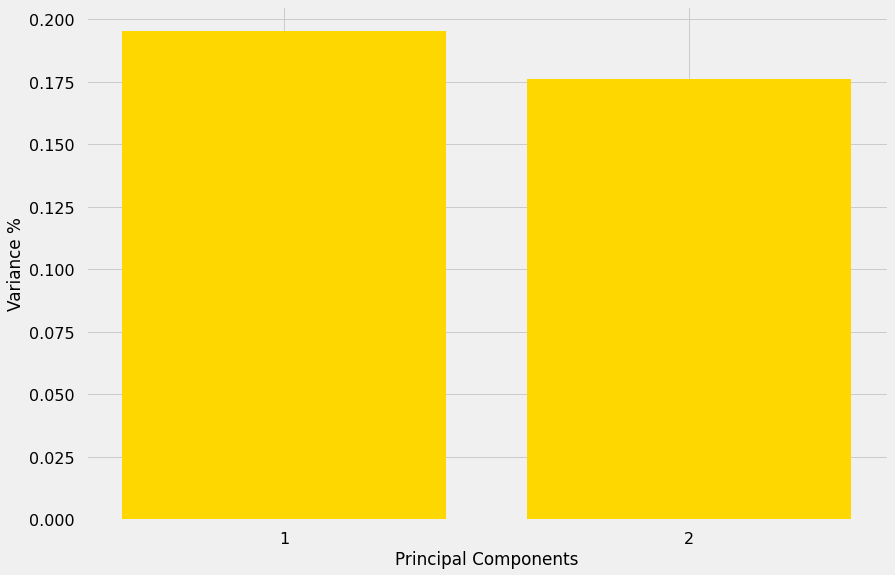

In [298]:
# Plotting the variances for each PC
plt.style.use("fivethirtyeight")
PC = range(1, pca.n_components_+1)
plt.bar(PC, pca.explained_variance_ratio_, color='gold')
plt.xlabel('Principal Components')
plt.ylabel('Variance %')
plt.xticks(PC)

# Putting components in a dataframe for later
PCA_components = pd.DataFrame(principalComponents)


In [299]:
pca.explained_variance_ratio_.sum()

0.371434881087525

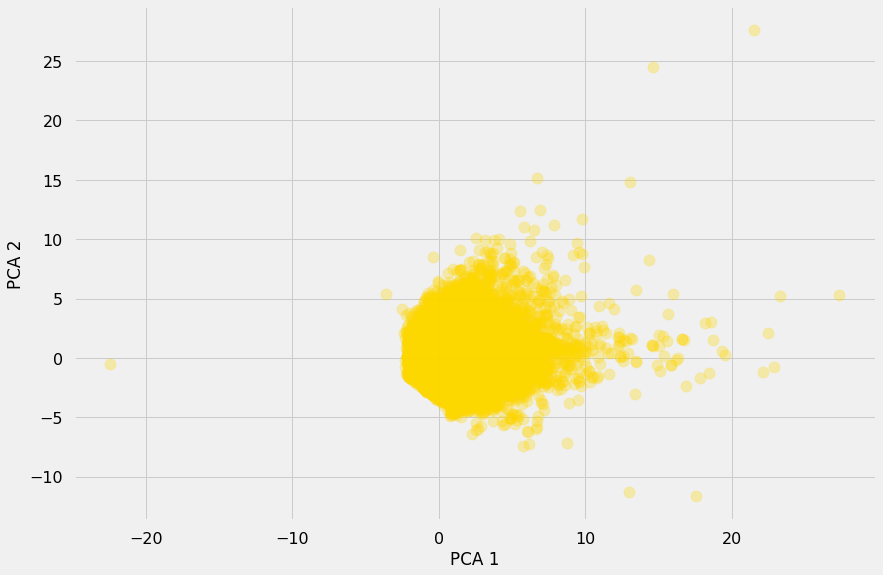

In [294]:
plt.scatter(PCA_components[0], PCA_components[1], alpha=.3, color='gold')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()


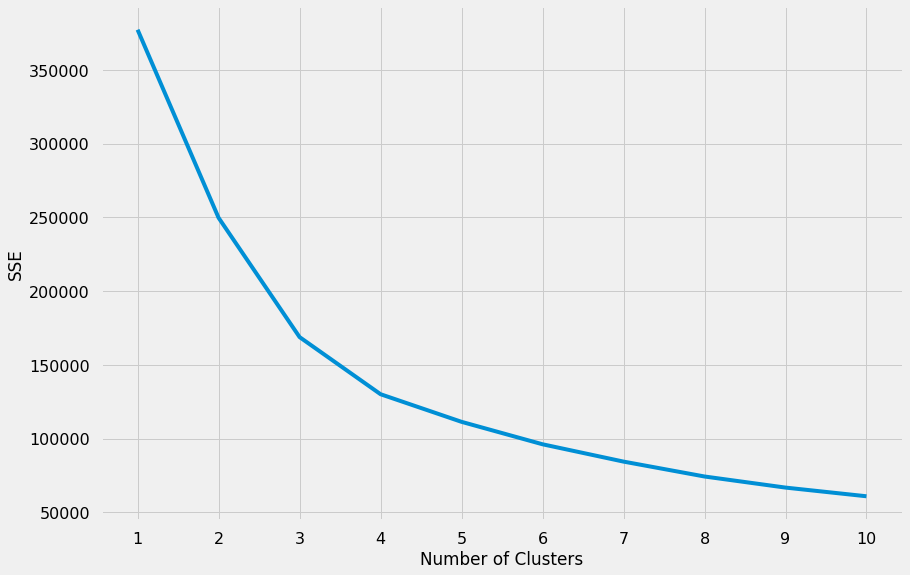

In [295]:
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42}
# A list holds the SSE values for each k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(PCA_components.iloc[:,:])
    sse.append(kmeans.inertia_)

#plot:
    
plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()
    


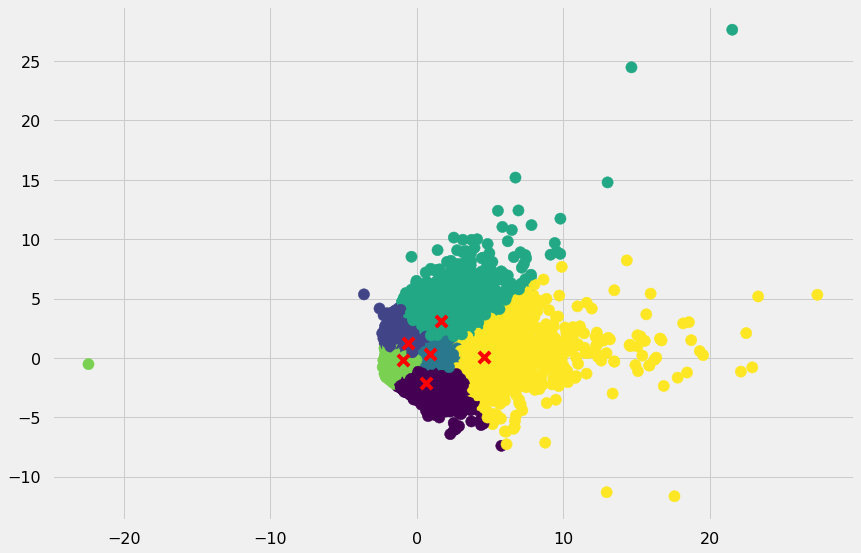

In [290]:
model = KMeans(n_clusters=6)
model.fit(PCA_components.iloc[:,:2])

labels = model.predict(PCA_components.iloc[:,:2])

#plot
plt.scatter(PCA_components[0], PCA_components[1], c=labels)
centers = np.array(model.cluster_centers_)
plt.scatter(centers[:,0], centers[:,1], marker="x", color='r')

plt.show()


In [312]:
df_with_clusters = df.copy()
df_with_clusters.head()

,review_score,price,freight_value,boleto,credit_card,debit_card,diff_approved,diff_carrier,diff_customer,diff_estimate,diff_est_del,cluster
0,4.0,29.99,8.72,0.0,1.0,0.0,0.007431,2.373924,8.436574,15.544063,7.107488,3
1,4.0,118.70,22.76,1.0,0.0,0.0,1.279745,1.742627,13.782037,19.137766,5.355729,5
2,5.0,159.90,19.22,0.0,3.0,0.0,0.011505,0.216100,9.394213,26.639711,17.245498,1
3,5.0,45.00,27.20,0.0,1.0,0.0,0.012419,3.758252,13.208750,26.188819,12.980069,3
4,5.0,19.90,8.72,0.0,1.0,0.0,0.042940,0.936053,2.873877,12.112049,9.238171,3


In [40]:

df_with_clusters = pd.concat([df.reset_index(drop = True), pd.DataFrame(principalComponents)], axis = 1)
df_with_clusters.columns.values[-2:] = ['Component 1', 'Component 2']
df_with_clusters['Clusters'] = model.labels_

df_with_clusters.head()

,review_score,price,freight_value,product_name_lenght,product_description_lenght,product_photos_qty,boleto,credit_card,debit_card,voucher,diff_approved,diff_carrier,diff_customer,diff_estimate,diff_est_del,customer_capital,customer_region_centro_oeste,customer_region_nordeste,customer_region_norte,customer_region_sudeste,customer_region_sul,product_category_name_bebes,product_category_name_beleza_saude,product_category_name_brinquedos,product_category_name_cama_mesa_banho,product_category_name_consoles_games,product_category_name_construcao_ferramentas_construcao,product_category_name_cool_stuff,product_category_name_eletrodomesticos,product_category_name_eletronicos,product_category_name_eletroportateis,product_category_name_esporte_lazer,product_category_name_fashion_bolsas_e_acessorios,product_category_name_ferramentas_jardim,product_category_name_informatica_acessorios,product_category_name_instrumentos_musicais,product_category_name_livros_interesse_geral,product_category_name_malas_acessorios,product_category_name_moveis_decoracao,product_category_name_moveis_escritorio,product_category_name_no info,product_category_name_papelaria,product_category_name_perfumaria,product_category_name_pet_shop,product_category_name_relogios_presentes,product_category_name_telefonia,product_category_name_utilidades_domesticas,Component 1,Component 2,Clusters
0,4.0,29.99,8.72,40.0,268.0,4.0,0.0,1.0,0.0,2.0,0.007431,2.373924,8.436574,15.544063,7.107488,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,-1.830936,0.398438,0
1,4.0,118.70,22.76,29.0,178.0,1.0,1.0,0.0,0.0,0.0,1.279745,1.742627,13.782037,19.137766,5.355729,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1.167187,1.766109,3
2,5.0,159.90,19.22,46.0,232.0,1.0,0.0,3.0,0.0,0.0,0.011505,0.216100,9.394213,26.639711,17.245498,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.504070,-1.240921,1
3,5.0,45.00,27.20,59.0,468.0,3.0,0.0,1.0,0.0,0.0,0.012419,3.758252,13.208750,26.188819,12.980069,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1.262482,-0.825174,1
4,5.0,19.90,8.72,38.0,316.0,4.0,0.0,1.0,0.0,0.0,0.042940,0.936053,2.873877,12.112049,9.238171,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,-2.308662,0.064170,0


## Clusters EDA

In [313]:
conditions = [
    df_with_clusters['cluster'] == 0,
    df_with_clusters['cluster'] == 1,
    df_with_clusters['cluster'] == 2,
    df_with_clusters['cluster'] == 3,
    df_with_clusters['cluster'] == 4,
    df_with_clusters['cluster'] == 5
]

values = ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5', 'Cluster 6']

df_with_clusters['cluster_name'] = np.select(conditions,values)
df_with_clusters.head()

,review_score,price,freight_value,boleto,credit_card,debit_card,diff_approved,diff_carrier,diff_customer,diff_estimate,diff_est_del,cluster,cluster_name
0,4.0,29.99,8.72,0.0,1.0,0.0,0.007431,2.373924,8.436574,15.544063,7.107488,3,Cluster 4
1,4.0,118.70,22.76,1.0,0.0,0.0,1.279745,1.742627,13.782037,19.137766,5.355729,5,Cluster 6
2,5.0,159.90,19.22,0.0,3.0,0.0,0.011505,0.216100,9.394213,26.639711,17.245498,1,Cluster 2
3,5.0,45.00,27.20,0.0,1.0,0.0,0.012419,3.758252,13.208750,26.188819,12.980069,3,Cluster 4
4,5.0,19.90,8.72,0.0,1.0,0.0,0.042940,0.936053,2.873877,12.112049,9.238171,3,Cluster 4


In [314]:
df_with_clusters['cluster_name'].value_counts()

Cluster 4    39495
Cluster 2    25477
Cluster 6    17448
Cluster 1     6347
Cluster 5     2108
Cluster 3     1434
Name: cluster_name, dtype: int64

In [315]:
cluster_1 = df_with_clusters[df_with_clusters['cluster'] == 0]
cluster_2 = df_with_clusters[df_with_clusters['cluster'] == 1]
cluster_3 = df_with_clusters[df_with_clusters['cluster'] == 2]
cluster_4 = df_with_clusters[df_with_clusters['cluster'] == 3]
cluster_5 = df_with_clusters[df_with_clusters['cluster'] == 4]
cluster_6 = df_with_clusters[df_with_clusters['cluster'] == 5]

### Reviews

In [316]:
rs_prop_1 = cluster_1['review_score'].value_counts(normalize=True).reset_index().rename(columns = {'review_score': 'percent',
                                                                                                   'index':'review_score'})
rs_prop_1['Cluster'] = 'Cluster 1'

rs_prop_2 = cluster_2['review_score'].value_counts(normalize=True).reset_index().rename(columns = {'review_score': 'percent',
                                                                                                   'index':'review_score'})
rs_prop_2['Cluster'] = 'Cluster 2'

rs_prop_3 = cluster_3['review_score'].value_counts(normalize=True).reset_index().rename(columns = {'review_score': 'percent',
                                                                                                   'index':'review_score'})
rs_prop_3['Cluster'] = 'Cluster 3'

rs_prop_4 = cluster_4['review_score'].value_counts(normalize=True).reset_index().rename(columns = {'review_score': 'percent',
                                                                                                   'index':'review_score'})
rs_prop_4['Cluster'] = 'Cluster 4'

rs_prop_5 = cluster_5['review_score'].value_counts(normalize=True).reset_index().rename(columns = {'review_score': 'percent',
                                                                                                   'index':'review_score'})
rs_prop_5['Cluster'] = 'Cluster 5'

rs_prop_6 = cluster_6['review_score'].value_counts(normalize=True).reset_index().rename(columns = {'review_score': 'percent',
                                                                                                   'index':'review_score'})
rs_prop_6['Cluster'] = 'Cluster 6'

rs_prop = pd.concat([rs_prop_1,rs_prop_2, rs_prop_3, rs_prop_4, rs_prop_5, rs_prop_6])
rs_prop

,review_score,percent,Cluster
0,1.0,0.684890,Cluster 1
1,2.0,0.121475,Cluster 1
2,4.0,0.099102,Cluster 1
3,5.0,0.094533,Cluster 1
0,5.0,0.648389,Cluster 2
1,4.0,0.222083,Cluster 2
2,1.0,0.095105,Cluster 2
3,2.0,0.034423,Cluster 2
0,5.0,0.665969,Cluster 3
1,4.0,0.201534,Cluster 3


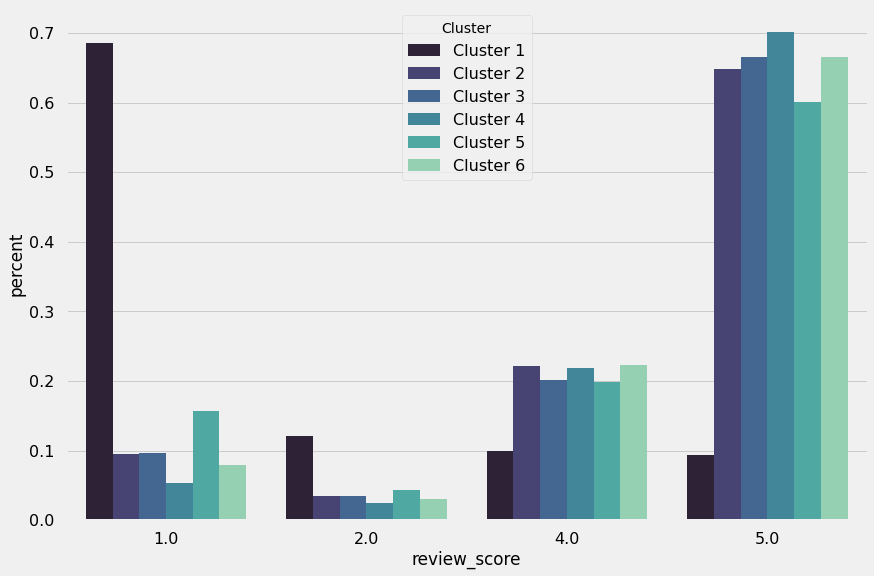

In [317]:
sns.barplot(x='review_score',
            y = 'percent',
            hue = 'Cluster',
            data = rs_prop,
            palette = 'mako')
plt.show()

### Price

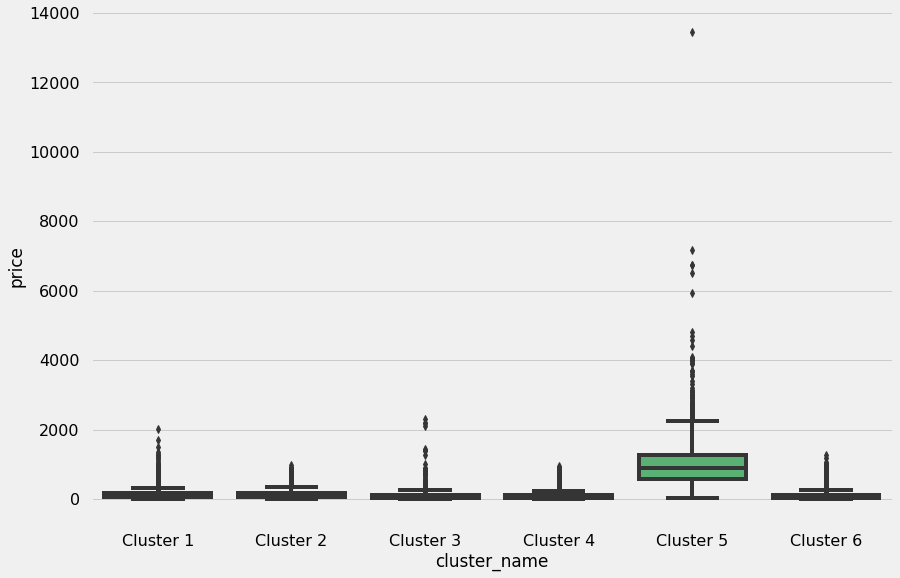

In [318]:
ax = sns.boxplot(y = 'price',
                 x = 'cluster_name',
                 data = df_with_clusters,
                 palette = 'viridis',
                 order=['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5', 'Cluster 6'])
plt.show()

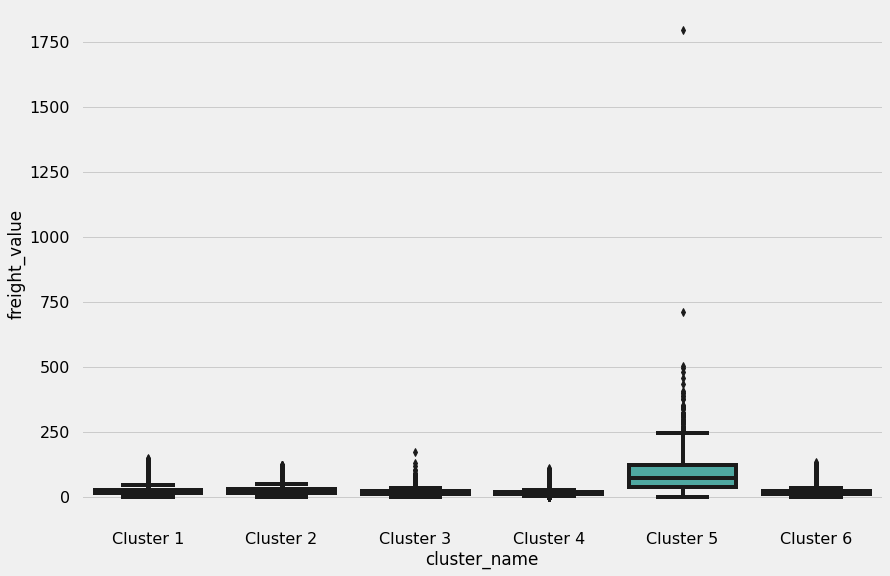

In [319]:
ax = sns.boxplot(y = 'freight_value',
            x = 'cluster_name',
            data = df_with_clusters,
            palette = 'mako',
            order=['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5', 'Cluster 6'])
plt.show()

### Payment type

In [320]:
pmt_type = df_with_clusters[['boleto','credit_card', 'debit_card', 'cluster_name']]
pmt_type.head()

,boleto,credit_card,debit_card,cluster_name
0,0.0,1.0,0.0,Cluster 4
1,1.0,0.0,0.0,Cluster 6
2,0.0,3.0,0.0,Cluster 2
3,0.0,1.0,0.0,Cluster 4
4,0.0,1.0,0.0,Cluster 4


In [321]:
pmt_type.groupby('cluster_name').sum()

,boleto,credit_card,debit_card
cluster_name,,,
Cluster 1,881.0,19948.0,0.0
Cluster 2,68.0,122932.0,0.0
Cluster 3,0.0,3.0,1435.0
Cluster 4,1.0,96311.0,0.0
Cluster 5,292.0,13753.0,3.0
Cluster 6,16980.0,1105.0,0.0


Não há diferença entre grupos em relação a tipo de pagamento.

### Região

In [97]:
df_regiao = df_with_clusters[['customer_region_centro_oeste',
                              'customer_region_nordeste',
                              'customer_region_norte',
                              'customer_region_sudeste',
                              'customer_region_sul',
                              'cluster_name']]

In [98]:
df_regiao.head()

,customer_region_centro_oeste,customer_region_nordeste,customer_region_norte,customer_region_sudeste,customer_region_sul,cluster_name
0,0,0,0,1,0,Cluster 1
1,0,1,0,0,0,CLuster 4
2,1,0,0,0,0,Cluster 2
3,0,1,0,0,0,Cluster 2
4,0,0,0,1,0,Cluster 1


In [99]:
regiao_grouped = df_regiao.groupby('cluster_name').sum()
regiao_grouped

,customer_region_centro_oeste,customer_region_nordeste,customer_region_norte,customer_region_sudeste,customer_region_sul
cluster_name,,,,,
CLuster 4,313.0,80.0,5.0,15603.0,1531.0
Cluster 1,133.0,28.0,0.0,37195.0,1175.0
Cluster 2,2056.0,5497.0,1074.0,4002.0,7649.0
Cluster 3,650.0,2319.0,499.0,2141.0,1937.0


In [100]:
regiao_grouped.idxmax(axis=1)

cluster_name
CLuster 4     customer_region_sudeste
Cluster 1     customer_region_sudeste
Cluster 2         customer_region_sul
Cluster 3    customer_region_nordeste
dtype: object

#### Capital

In [102]:
capital_prop_1 = cluster_1['customer_capital'].value_counts(normalize=True).reset_index().rename(columns = {'customer_capital': 'percent',
                                                                                                   'index':'customer_capital'})
capital_prop_1['Cluster'] = 'Cluster 1'

capital_prop_2 = cluster_2['customer_capital'].value_counts(normalize=True).reset_index().rename(columns = {'customer_capital': 'percent',
                                                                                                   'index':'customer_capital'})
capital_prop_2['Cluster'] = 'Cluster 2'

capital_prop_3 = cluster_3['customer_capital'].value_counts(normalize=True).reset_index().rename(columns = {'customer_capital': 'percent',
                                                                                                   'index':'customer_capital'})
capital_prop_3['Cluster'] = 'Cluster 3'

capital_prop_4 = cluster_4['customer_capital'].value_counts(normalize=True).reset_index().rename(columns = {'customer_capital': 'percent',
                                                                                                   'index':'customer_capital'})
capital_prop_4['Cluster'] = 'Cluster 4'

capital_prop = pd.concat([capital_prop_1,capital_prop_2, capital_prop_3, capital_prop_4])
capital_prop

,customer_capital,percent,Cluster
0,0,0.609469,Cluster 1
1,1,0.390531,Cluster 1
0,0,0.649094,Cluster 2
1,1,0.350906,Cluster 2
0,0,0.630607,Cluster 3
1,1,0.369393,Cluster 3
0,0,0.638703,Cluster 4
1,1,0.361297,Cluster 4


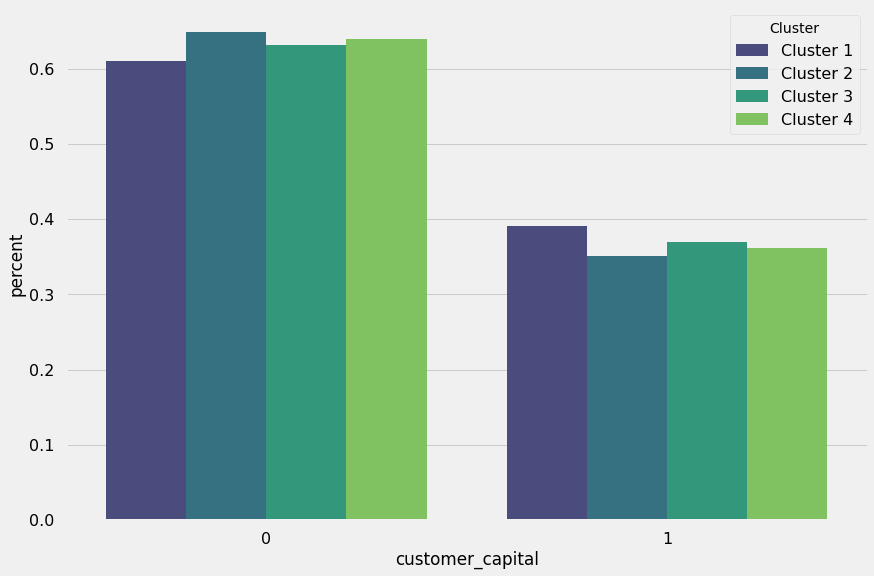

In [103]:
#Plot capital

sns.barplot(x='customer_capital',
            y = 'percent',
            hue = 'Cluster',
            data = capital_prop,
            palette = 'viridis')
plt.show()

### Categoria de Produtos

In [104]:
categ_prod = df_with_clusters[['product_category_name_bebes',
'product_category_name_beleza_saude',
'product_category_name_brinquedos',
'product_category_name_cama_mesa_banho',
'product_category_name_consoles_games',
'product_category_name_construcao_ferramentas_construcao',
'product_category_name_cool_stuff',
'product_category_name_eletrodomesticos',
'product_category_name_eletronicos',
'product_category_name_eletroportateis',
'product_category_name_esporte_lazer',
'product_category_name_fashion_bolsas_e_acessorios',
'product_category_name_ferramentas_jardim',
'product_category_name_informatica_acessorios',
'product_category_name_instrumentos_musicais',
'product_category_name_livros_interesse_geral',
'product_category_name_malas_acessorios',
'product_category_name_moveis_decoracao',
'product_category_name_moveis_escritorio',
'product_category_name_no info',
'product_category_name_papelaria',
'product_category_name_perfumaria',
'product_category_name_pet_shop',
'product_category_name_relogios_presentes',
'product_category_name_telefonia',
'product_category_name_utilidades_domesticas',
'cluster_name']]

In [105]:
categ_prod.head()

,product_category_name_bebes,product_category_name_beleza_saude,product_category_name_brinquedos,product_category_name_cama_mesa_banho,product_category_name_consoles_games,product_category_name_construcao_ferramentas_construcao,product_category_name_cool_stuff,product_category_name_eletrodomesticos,product_category_name_eletronicos,product_category_name_eletroportateis,product_category_name_esporte_lazer,product_category_name_fashion_bolsas_e_acessorios,product_category_name_ferramentas_jardim,product_category_name_informatica_acessorios,product_category_name_instrumentos_musicais,product_category_name_livros_interesse_geral,product_category_name_malas_acessorios,product_category_name_moveis_decoracao,product_category_name_moveis_escritorio,product_category_name_no info,product_category_name_papelaria,product_category_name_perfumaria,product_category_name_pet_shop,product_category_name_relogios_presentes,product_category_name_telefonia,product_category_name_utilidades_domesticas,cluster_name
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,Cluster 1
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,CLuster 4
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Cluster 2
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,Cluster 2
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,Cluster 1


In [106]:
categ_grouped = categ_prod.groupby('cluster_name').sum()
categ_grouped

,product_category_name_bebes,product_category_name_beleza_saude,product_category_name_brinquedos,product_category_name_cama_mesa_banho,product_category_name_consoles_games,product_category_name_construcao_ferramentas_construcao,product_category_name_cool_stuff,product_category_name_eletrodomesticos,product_category_name_eletronicos,product_category_name_eletroportateis,product_category_name_esporte_lazer,product_category_name_fashion_bolsas_e_acessorios,product_category_name_ferramentas_jardim,product_category_name_informatica_acessorios,product_category_name_instrumentos_musicais,product_category_name_livros_interesse_geral,product_category_name_malas_acessorios,product_category_name_moveis_decoracao,product_category_name_moveis_escritorio,product_category_name_no info,product_category_name_papelaria,product_category_name_perfumaria,product_category_name_pet_shop,product_category_name_relogios_presentes,product_category_name_telefonia,product_category_name_utilidades_domesticas
cluster_name,,,,,,,,,,,,,,,,,,,,,,,,,,
CLuster 4,494.0,1425.0,673.0,2023.0,243.0,107.0,498.0,158.0,825.0,59.0,1422.0,376.0,681.0,1751.0,90.0,125.0,126.0,1248.0,62.0,828.0,420.0,553.0,305.0,762.0,992.0,1026.0
Cluster 1,1139.0,3879.0,1918.0,4693.0,372.0,367.0,1398.0,382.0,942.0,255.0,3479.0,967.0,1280.0,2378.0,207.0,229.0,523.0,2528.0,17.0,214.0,1098.0,1565.0,853.0,2475.0,1375.0,2966.0
Cluster 2,717.0,2200.0,795.0,1747.0,203.0,180.0,1161.0,141.0,338.0,240.0,1740.0,346.0,964.0,1346.0,224.0,100.0,280.0,1727.0,296.0,92.0,500.0,657.0,380.0,1577.0,921.0,1121.0
Cluster 3,266.0,684.0,220.0,653.0,108.0,42.0,241.0,40.0,226.0,24.0,506.0,100.0,334.0,745.0,56.0,41.0,37.0,587.0,728.0,189.0,168.0,188.0,86.0,365.0,470.0,280.0


In [107]:
categ_grouped.idxmax(axis=1)

cluster_name
CLuster 4           product_category_name_cama_mesa_banho
Cluster 1           product_category_name_cama_mesa_banho
Cluster 2              product_category_name_beleza_saude
Cluster 3    product_category_name_informatica_acessorios
dtype: object

In [311]:
df_with_clusters.head()

,review_score,price,freight_value,boleto,credit_card,debit_card,cluster,cluster_name
0,4.0,29.99,8.72,0.0,1.0,0.0,0,Cluster 1
1,4.0,118.70,22.76,1.0,0.0,0.0,5,Cluster 6
2,5.0,159.90,19.22,0.0,3.0,0.0,0,Cluster 1
3,5.0,45.00,27.20,0.0,1.0,0.0,0,Cluster 1
4,5.0,19.90,8.72,0.0,1.0,0.0,0,Cluster 1


### Tempo de entrega

In [332]:
time_delivered = df_with_clusters[['diff_approved', 
                                   'diff_carrier',
                                   'diff_customer',
                                   'diff_estimate',
                                   'diff_est_del',
                                   'cluster_name']]

time_delivered.head()

,diff_approved,diff_carrier,diff_customer,diff_estimate,diff_est_del,cluster_name
0,0.007431,2.373924,8.436574,15.544063,7.107488,Cluster 4
1,1.279745,1.742627,13.782037,19.137766,5.355729,Cluster 6
2,0.011505,0.216100,9.394213,26.639711,17.245498,Cluster 2
3,0.012419,3.758252,13.208750,26.188819,12.980069,Cluster 4
4,0.042940,0.936053,2.873877,12.112049,9.238171,Cluster 4


In [333]:
time_del_grouped = time_delivered.groupby('cluster_name').mean().reset_index()
time_del_grouped

,cluster_name,diff_approved,diff_carrier,diff_customer,diff_estimate,diff_est_del
0,Cluster 1,0.373961,7.614619,34.522380,26.208562,-8.313819
1,Cluster 2,0.192774,3.003565,12.810440,31.046172,18.235732
2,Cluster 3,0.355374,2.918711,10.516954,21.585904,11.068950
3,Cluster 4,0.128537,2.294590,8.650613,18.611231,9.960617
4,Cluster 5,0.536389,4.282057,14.382651,26.619091,12.236440
5,Cluster 6,1.453212,3.770895,11.905235,23.572432,11.667197


In [335]:
tidy_time_del_grouped = time_del_grouped.melt(id_vars='cluster_name').rename(columns=str.title)
tidy_time_del_grouped

,Cluster_Name,Variable,Value
0,Cluster 1,diff_approved,0.373961
1,Cluster 2,diff_approved,0.192774
2,Cluster 3,diff_approved,0.355374
3,Cluster 4,diff_approved,0.128537
4,Cluster 5,diff_approved,0.536389
5,Cluster 6,diff_approved,1.453212
6,Cluster 1,diff_carrier,7.614619
7,Cluster 2,diff_carrier,3.003565
8,Cluster 3,diff_carrier,2.918711
9,Cluster 4,diff_carrier,2.294590


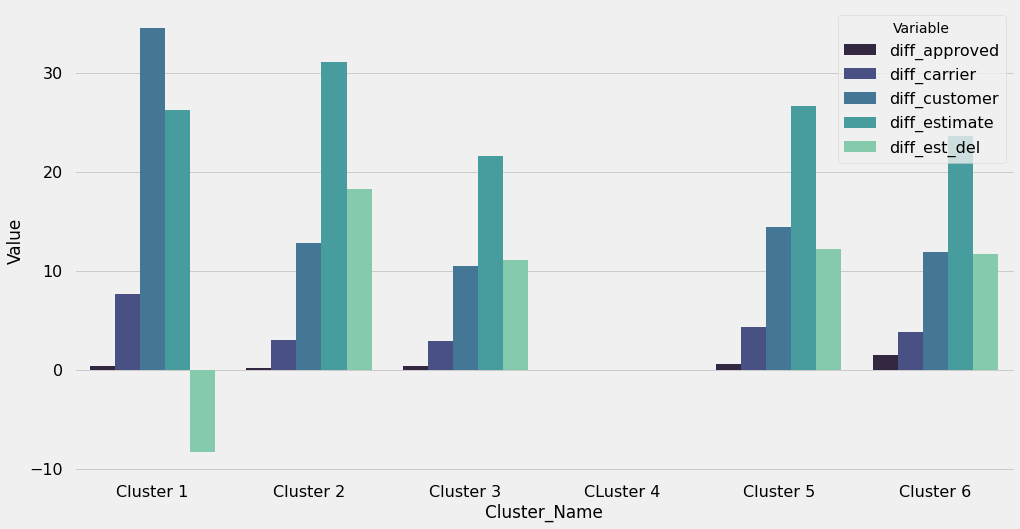

In [336]:
ax = fig, ax = plt.subplots(figsize=(15, 8))
ax = sns.barplot(x='Cluster_Name', 
                 y='Value', 
                 hue='Variable', 
                 data=tidy_time_del_grouped, 
                 ax=ax,
                 palette = 'mako',
                 order = ['Cluster 1', 'Cluster 2', 'Cluster 3', 'CLuster 4', 'Cluster 5', 'Cluster 6'])
sns.despine(fig)